In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import json
import subprocess
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy
%matplotlib inline
# sns.set(font_scale=1.1)
# sns.set_theme(style='white')
sns.set_theme()
sns.set_style({'axes.facecolor': 'white',
 'axes.edgecolor': 'black',
 'axes.grid': True,
 'axes.axisbelow': 'line',
 'axes.labelcolor': 'black',
 'figure.facecolor': 'white',
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'text.color': 'black',
 'xtick.color': 'black',
 'ytick.color': 'black',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': False,
 'image.cmap': 'viridis',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif'],
 'xtick.bottom': True,
 'xtick.top': False,
 'ytick.left': True,
 'ytick.right': False,
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True})


np.random.seed(1)
np.set_printoptions(precision=6, suppress=True)
plot_height = 10
marker_size, line_width = 25, 2.0
label_size, legend_size, title_size = 14, 10, 15

linewidth, edgecolor = 0.1, 'black'
sizes = (100, 50)
palette = sns.color_palette("Blues", as_cmap=True)

dataset_dict = {'cifar10': 'CIFAR-10', 'cifar100': 'CIFAR-100'}
sharpness_dict = {
    'avg': {False: 'Standard avg-case sharpness', True: 'Adaptive avg-case sharpness'}, 
    'avg_l2': {False: 'Standard $\mathcal{N}$ avg-case sharpness', True: 'Adaptive $\mathcal{N}$ avg-case sharpness'}, 
    'avg_linf': {False: 'Standard $\mathcal{U}$ avg-case sharpness', True: 'Adaptive $\mathcal{U}$ avg-case sharpness'}, 
    'm_apgd': {False: 'Standard worst-case sharpness', True: 'Adaptive worst-case sharpness'},
    'm_apgd_l2': {False: 'Standard $\ell_2$ worst-case sharpness', True: 'Adaptive $\ell_2$ worst-case sharpness'},
    'm_apgd_linf': {False: 'Standard $\ell_\infty$ worst-case sharpness', True: 'Adaptive $\ell_\infty$ worst-case sharpness'}
}
model_dict = {'wrn28_10': 'WRN-28-10', 'resnet56_nosequential': 'ResNet-56', 'resnext29_32x4d_nosequential': 'ResNeXt-29 (32x4d)', 'densenet100_nosequential': 'DenseNet-100'}
err_dict = {'test_err': 'Test error', 'test_err_corrupt': 'Test error (corruptions)'}


def adjust_legend(texts):
    for t in texts:
        if t.get_text() in ('data_augm', 'randaug'):
            t.set_text('Augment.')
        if t.get_text() == 'train_lr':
            t.set_text('Learn. rate')
        if t.get_text() == 'train_lr_log':
            t.set_text('log$_2$ LR')
        if t.get_text() == 'train_rho':
            t.set_text('$\\rho$ of SAM')
        if t.get_text() == 'mixup':
            t.set_text('Mixup')

def get_optimizer(model_name):
    if 'SGD' in model_name:
        return 'SGD'
    elif 'ASAM_BN' in model_name:
        return 'ASAM_BN'
    elif 'SAM_BN' in model_name:
        return 'SAM_BN'
    else:
        return 'UNKNOWN'
def get_lp(model_name):
    if 'SGD' in model_name:
        return 'SGD'
    elif '_p2' in model_name:
        return '2'
    elif '_pinfinity' in model_name:
        return 'infinity'
    else:
        return 'UNKNOWN'
def get_normalization(model_name):
    if 'elementwiseTrue' in model_name:
        return 'elementwise'
    elif 'layerwiseTrue' in model_name:
        return 'layerwise'
    elif 'filterwiseTrue' in model_name:
        return 'filterwise'
    else:
        return 'NoNormalization'
    
def get_perturbed_layers(model_name):
    if 'onlyBN' in model_name:
        return 'onlyBN'
    elif 'noBN' in model_name:
        return 'noBN'
    else:
        return 'all'
def get_aa(model_name):
    if 'autoaugmentTrue' in model_name:
        return True
    elif 'autoaugmentFalse' in model_name:
        return False
    else: 
        return 'UNKNOWN'

def extract_param_from_npy(model_path, param_name):
    if 'lr_schedule=cosine' in model_path:
        model_path = model_path.replace('models', 'exps/s_vs_g_vit_v2')
    elif 'model=vit_exp' in model_path and 'lr_schedule=cyclic' in model_path:
        model_path = model_path.replace('models', 'exps/s_vs_g_vit_sgd')
    elif 'model=resnet18' in model_path and 'lr_schedule=cyclic' in model_path:
        model_path = model_path.replace('models', 'exps/s_vs_g_cnn')
    model_path = model_path.replace(' epoch=200.pth', '.npy').replace(' epoch=130.pth', '.npy')
    param_val = np.load(model_path, allow_pickle=True).item()[param_name] 
    # p = df_all['model_path'].values[0]
    # p = p.replace('models', 'exps/s_vs_g').replace(' epoch=200.pth', '.npy')
    # np.load(p, allow_pickle=True).item()['no_data_augm']   
    return param_val

def postprocess_df_max(df_all):
    if 'output' in df_all:
        df_all = df_all.drop('output', axis=1)
    df_all['model_name'] = df_all['model_path'].apply(lambda x: x.split('/')[-1])    
    df_all['lp_train'] = df_all['model_name'].apply(lambda x: get_lp(x))
    df_all['optimizer_train'] = df_all['model_name'].apply(lambda x: get_optimizer(x))
    df_all['normalization_train'] = df_all['model_name'].apply(lambda x: get_normalization(x))
    df_all['perturbed_layers_train'] = df_all['model_name'].apply(lambda x: get_perturbed_layers(x))
    df_all['autoaugment'] = df_all['model_name'].apply(lambda x: get_aa(x))
    df_all['model'] = df_all['model'].apply(lambda x: model_dict[x])
    return df_all

def postprocess_df_controlled(df_all, path):
    df_all['train_lr'] = df_all['model_path'].apply(lambda x: float(x.split('lr_max=')[1].split(' ')[0]))
    df_all['train_rho'] = df_all['model_path'].apply(lambda x: float(x.split('sam_rho=')[1].split(' ')[0]))
    df_all['randaug'] = df_all['model_path'].apply(lambda x: x.split('randaug=')[1].split(' ')[0] == 'True')
    if path.split('/')[-1] in ['logs_eval_cifar10_controlled', 'logs_eval_cifar10_controlled_norm', 'logs_eval_cifar10_controlled_swa', 'logs_eval_cifar10_controlled_swa_norm']:
        df_all['data_augm'] = df_all['model_path'].apply(lambda x: not extract_param_from_npy(x, 'no_data_augm'))
    else:
        df_all['data_augm'] = df_all['model_path'].apply(lambda x: x.split('augm=')[1].split(' ')[0] == 'True')
    # print(df_all)
    df_all['mixup_p'] = df_all['model_path'].apply(lambda x: extract_param_from_npy(x, 'mixup_p'))
    df_all['mixup'] = df_all['mixup_p'] > 0
    return df_all

def read_jsons_as_df(path):
    pd_series = []
    for log_file in glob.glob(path):
        pd_series.append(pd.read_json(log_file, typ='series'))
    df_all = pd.DataFrame(pd_series)
    # if path.split('/')[-1] in ['logs_eval_cifar10_controlled', 'logs_eval_cifar10_controlled_norm', 'logs_eval_cifar10_controlled_swa', 'logs_eval_cifar10_controlled_swa_norm']:
    if 'controlled' in path or 'final' in path:
        df_all = postprocess_df_controlled(df_all, path)
    elif 'vit' not in path:
        df_all = postprocess_df_max(df_all)
    if path == '../logs_eval_corruptions/*':  # manual fix for a mistake in the json (`test_err_corrupt` got into `test_err`)
        # df_all = df_all.rename(columns={'test_err': ''})
        df_all['test_err_corrupt'] = df_all['test_err']
    if path == '../logs_eval/*':
        df_corrupt = read_jsons_as_df('../logs_eval_corruptions/*')
        df_all = pd.merge(df_all, df_corrupt[['model_path', 'test_err_corrupt']], on='model_path')
    # df_all['lp_norm'] = df_all['algorithm'].apply(lambda s: '$\ell_2$' if s in ('m_apgd', 'avg') else '$\ell_\infty$')
    # df_all['lp_norm'] = df_all['algorithm'].apply(lambda s: '$\ell_2$' if 'l2' in s else '$\ell_\infty$')
    df_all['train_lr_log'] = np.log2(df_all['train_lr'])
    return df_all

In [11]:
df_all_resnet_avg_l2 = read_jsons_as_df('../logs_final_resnet_avg_l2_more_n_iters/*')
df_all_vit_avg_l2 = read_jsons_as_df('../logs_final_vit_avg_l2_more_n_iters/*')
df_all_resnet_max_l2 = read_jsons_as_df('../logs_final_resnet_max_l2/*')
df_all_vit_max_l2 = read_jsons_as_df('../logs_final_vit_max_l2/*')
df_all_resnet_avg_linf = read_jsons_as_df('../logs_final_resnet_avg_linf_more_n_iters/*')
df_all_vit_avg_linf = read_jsons_as_df('../logs_final_vit_avg_linf_more_n_iters/*')
df_all_resnet_max_linf = read_jsons_as_df('../logs_final_resnet_max_linf/*')
df_all_vit_max_linf = read_jsons_as_df('../logs_final_vit_max_linf/*')

(2376, 50)


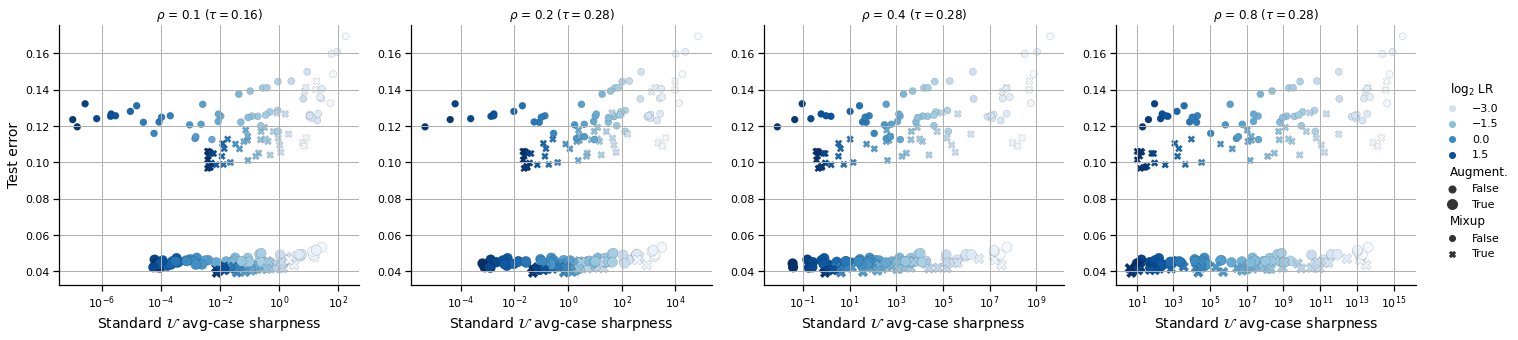

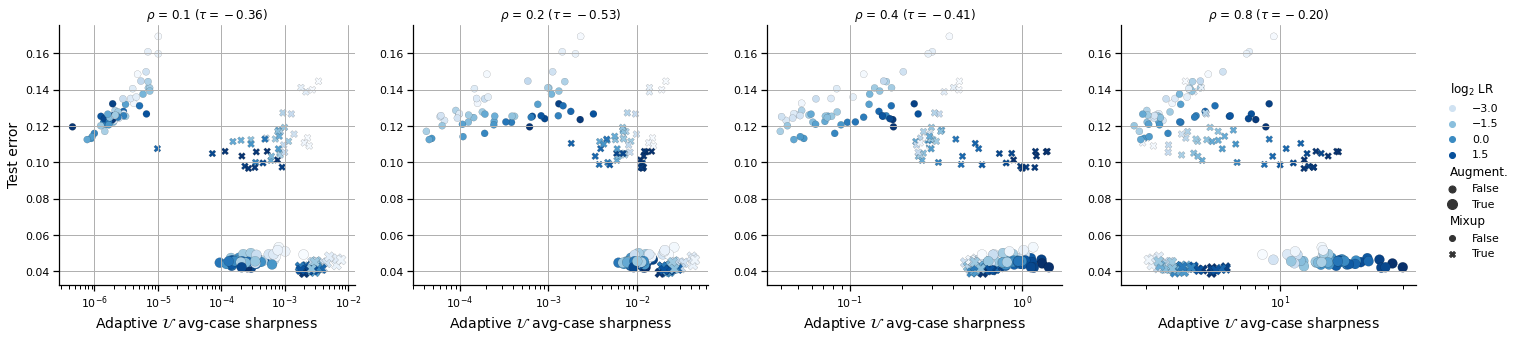

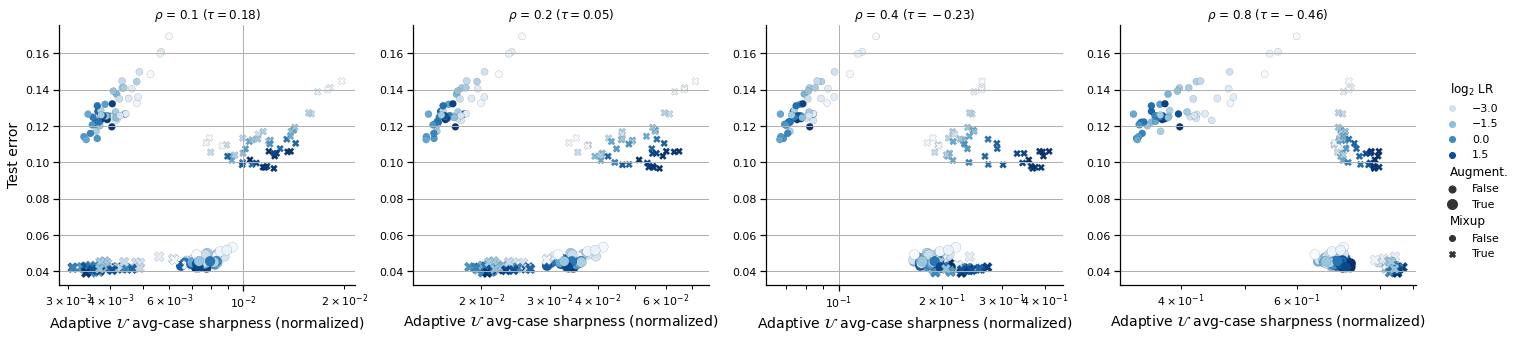

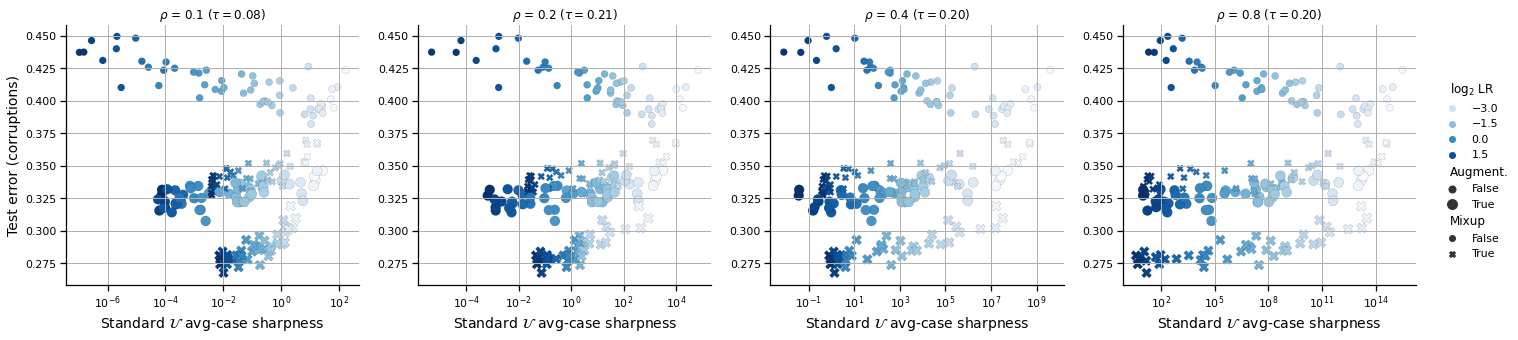

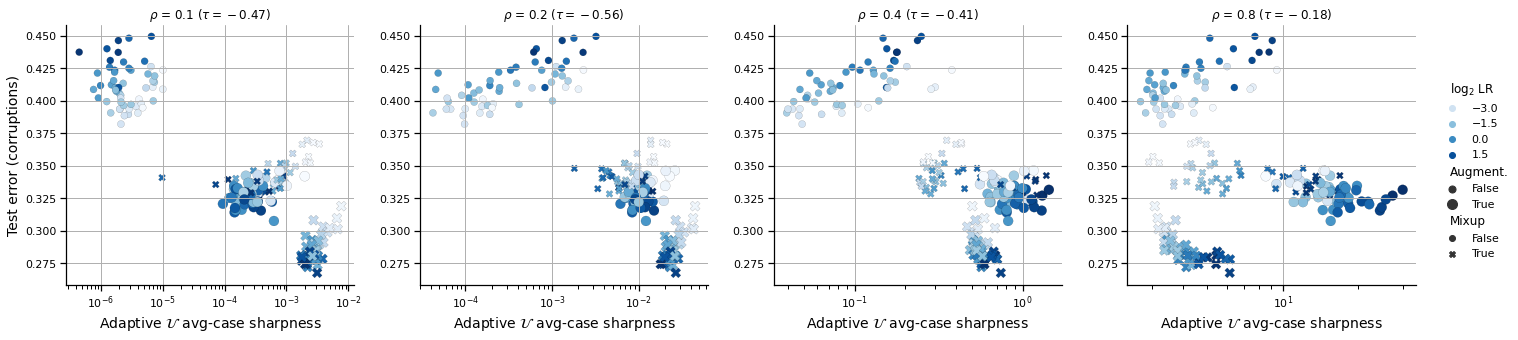

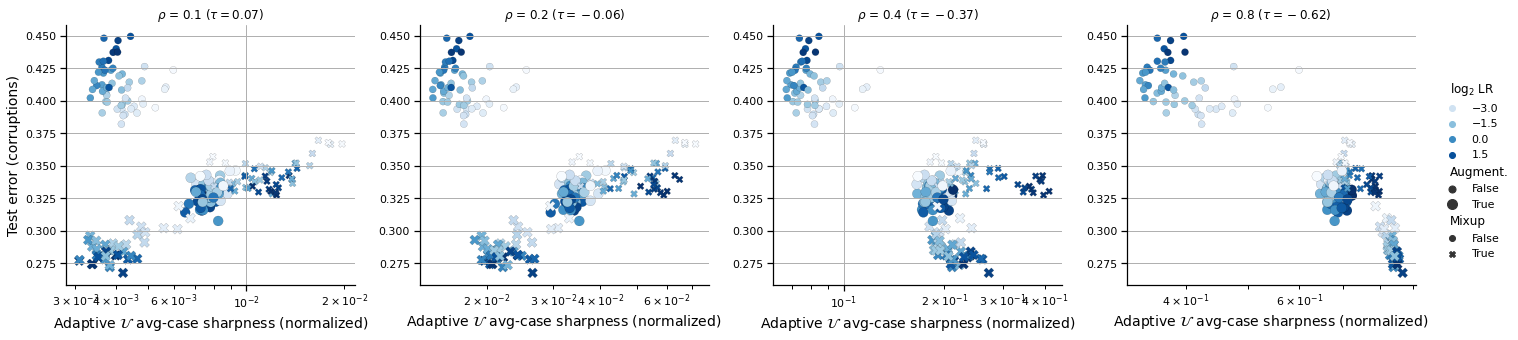

(2376, 52)


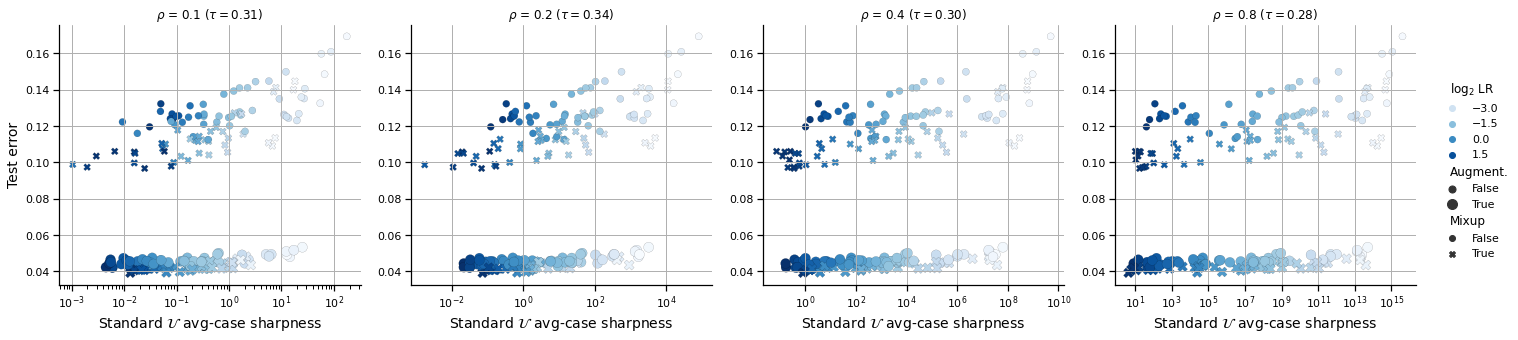

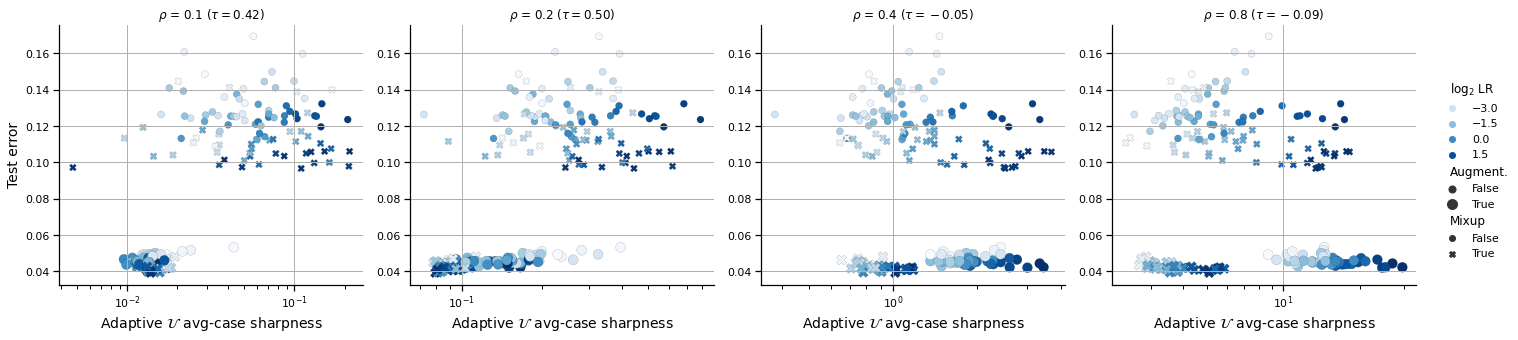

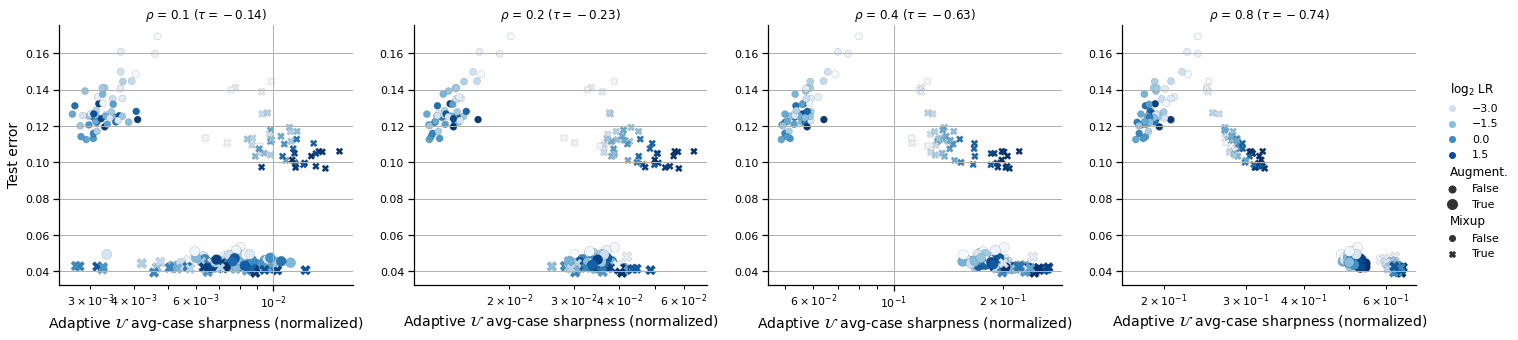

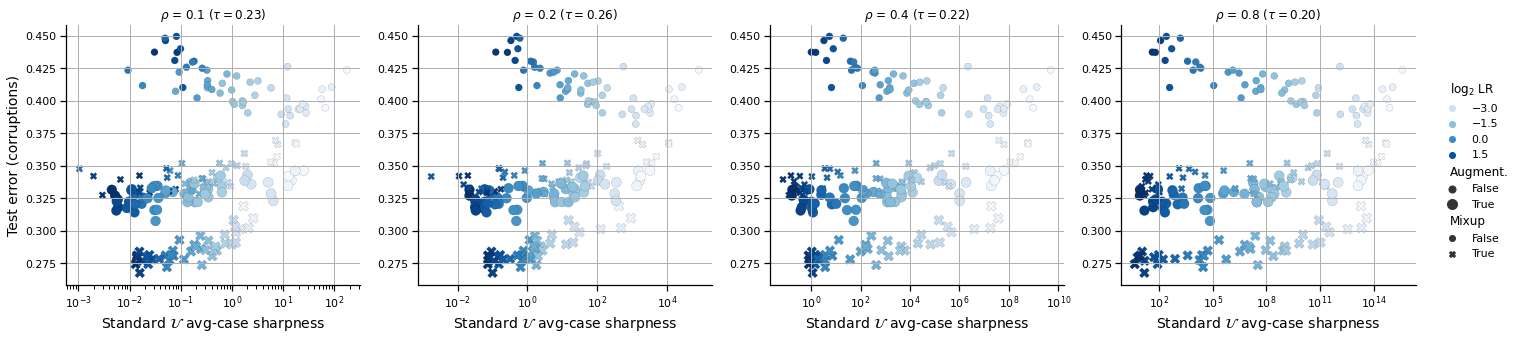

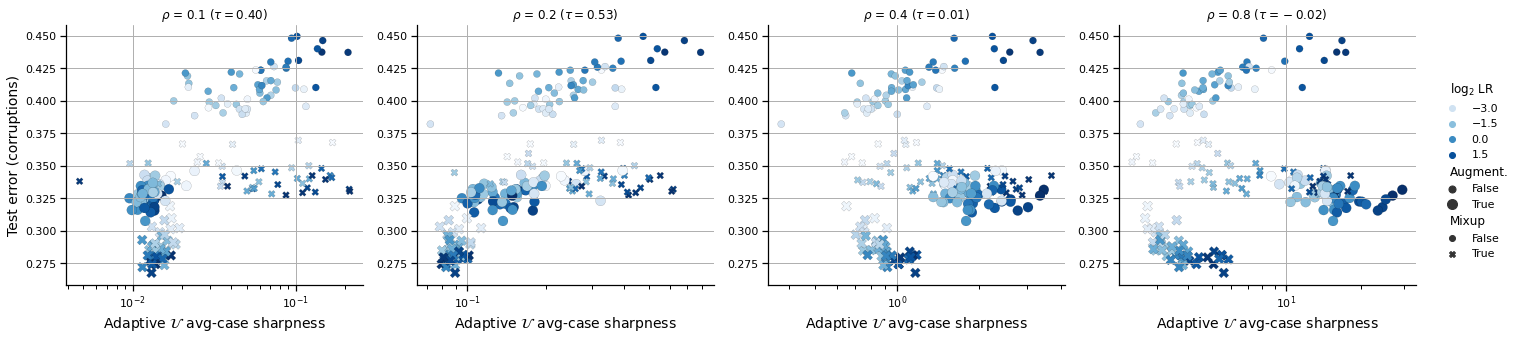

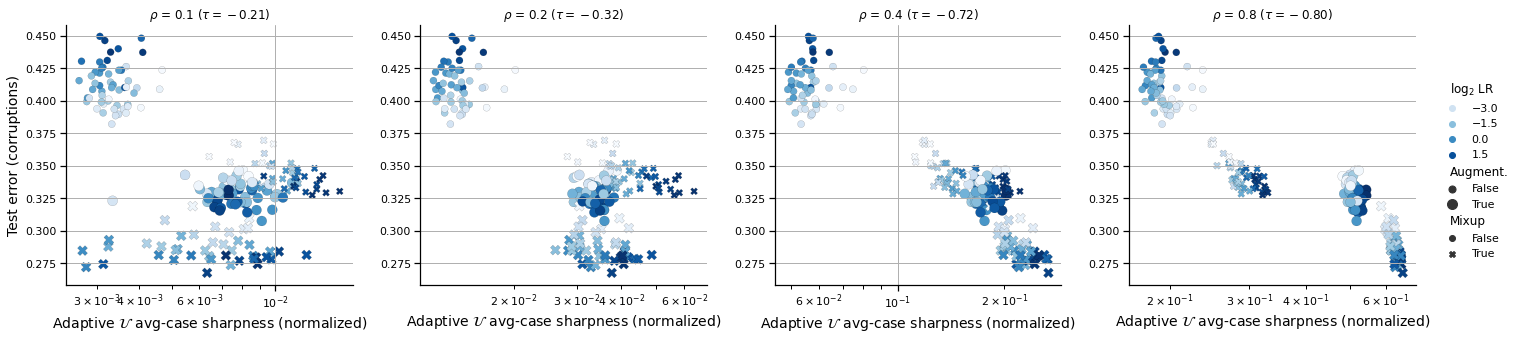

In [4]:
for df_all in [df_all_resnet_avg_l2, df_all_resnet_max_l2, df_all_resnet_avg_linf, df_all_resnet_max_linf, df_all_vit_avg_l2, df_all_vit_max_l2, df_all_vit_avg_linf, df_all_vit_max_linf]:
    print(df_all.shape)
    dataset, model = df_all['dataset'].min(), df_all['model'].min()

    for version in ['long', 'short']:
        for err in ['test_err', 'test_err_corrupt']:  #, 'test_err_corrupt']:
            # for algorithm in ['m_apgd_linf']:
            for algorithm in ['avg', 'avg_l2', 'avg_linf', 'm_apgd', 'm_apgd_l2', 'm_apgd_linf']:
                for adaptive in [False, True]:
                    for normalize_logits in [False, True]:
                        idx_global = (df_all['mixup'] >= False) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.01) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                        if idx_global.sum() > 0:
                            if version == 'short':
                                idx_global = idx_global & df_all['rho'].isin(np.sort(df_all[idx_global]['rho'].unique())[[0]])
                            df_relplot = df_all[idx_global].drop_duplicates(subset=['model_path', 'rho'])  # there could be duplicates due to crashes + rerunning (22:56 23 Jan crash time for 2th, 5th, and 6th ViTs worst-case runs)
                            # size: train_lr, train_rho
                            # style: model_type, randaug, mixup

                            if version == 'short':
                                rho = df_relplot['rho'].min()
                                # plt.figure(figsize=(5.5, 5.5))
                                plt.figure(figsize=(5.5, 3.8))
                                ax = sns.scatterplot(data=df_relplot, x="sharpness_obj", y=err, hue="train_lr_log", style="mixup", size="data_augm", linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
                                ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                ax.set_ylabel(err_dict[err], size=label_size)
                                tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'], df_relplot[err])
                                ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
                                ax.set_xscale('log')
                                adjust_legend(ax.get_legend().texts)
                                if algorithm != 'm_apgd_linf':
                                    ax.get_legend().remove()
                                    # g._legend.remove()
                            else:
                                g = sns.relplot(data=df_relplot, x="sharpness_obj", y=err, col="rho", hue="train_lr_log", style="mixup", size="data_augm", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)
                                
                                for i, rho in enumerate(sorted(df_relplot['rho'].unique())):
                                    idx_rho = df_relplot['rho'] == rho
                                    tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'][idx_rho], df_relplot[err][idx_rho])
                                    g.axes.flat[i].set_title(g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))

                                g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                g.set_ylabels(err_dict[err], size=label_size)
                                g.set(xscale='log')
                                # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                                # g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                                g.fig.subplots_adjust(top=0.86)
                                adjust_legend(g._legend.texts)
                            plt.savefig('../plots/sharpness_vs_generalization-dataset_{}-model_{}-{}-algorithm_{}-adaptive_{}-normalized_{}-version_{}.pdf'.format(dataset, model, err, algorithm, adaptive, normalize_logits, version), bbox_inches='tight')
                            plt.show()
                            # if version == 'long':
                            #     plt.show()
                            # else:
                            #     plt.clf()


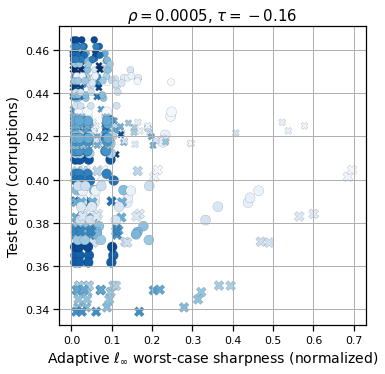

In [138]:
linewidth, edgecolor = 0.1, 'black'
sizes = (100, 50)

rho = df_relplot['rho'].min()
plt.figure(figsize=(5.5, 5.5))
ax = sns.scatterplot(data=df_relplot, x="sharpness_obj", y=err, hue="train_lr_log", style="mixup", size="data_augm", linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=sns.color_palette("Blues", as_cmap=True))#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
ax.set_ylabel(err_dict[err], size=label_size)
# plt.gca().set_aspect('equal')

tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'], df_relplot[err])
ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
adjust_legend(ax.get_legend().texts)
ax.get_legend().remove()

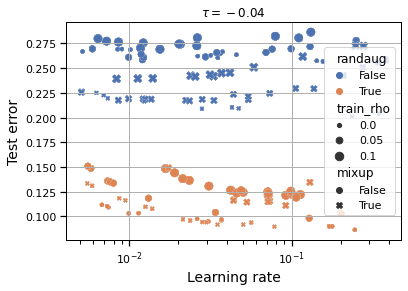

In [188]:
# slices (hue): lr, rho

col = 'rho'
x_name, y_name = 'train_lr', 'test_err'

idx_global = (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.1) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) 
if idx_global.sum() > 0:
    df_relplot = df_all[idx_global]
    ax = sns.scatterplot(data=df_relplot, x='train_lr', y='test_err', hue="randaug", style="mixup", size="train_rho", linewidth=linewidth) 
    # ax.grid()
    
    tau, p_value = scipy.stats.kendalltau(df_relplot['train_lr'], df_relplot['test_err'])
    ax.set_title('$\\tau={:.2f}$'.format(tau))
    
    ax.set_xlabel('Learning rate', size=label_size)
    ax.set_ylabel('Test error', size=label_size)
    ax.set(xscale='log')
    # ax.set(yscale='log')

In [2]:
df_all = read_jsons_as_df('../logs_final_resnet_max_linf/*')
# df_all = read_jsons_as_df('../logs_final_vit_max_linf/*')
dataset, model = df_all['dataset'].min(), df_all['model'].min()

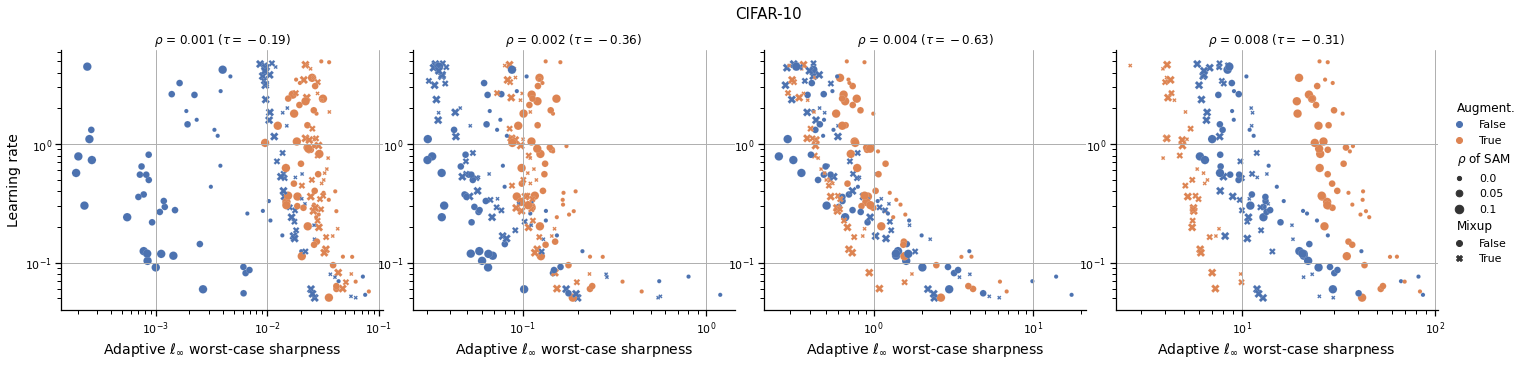

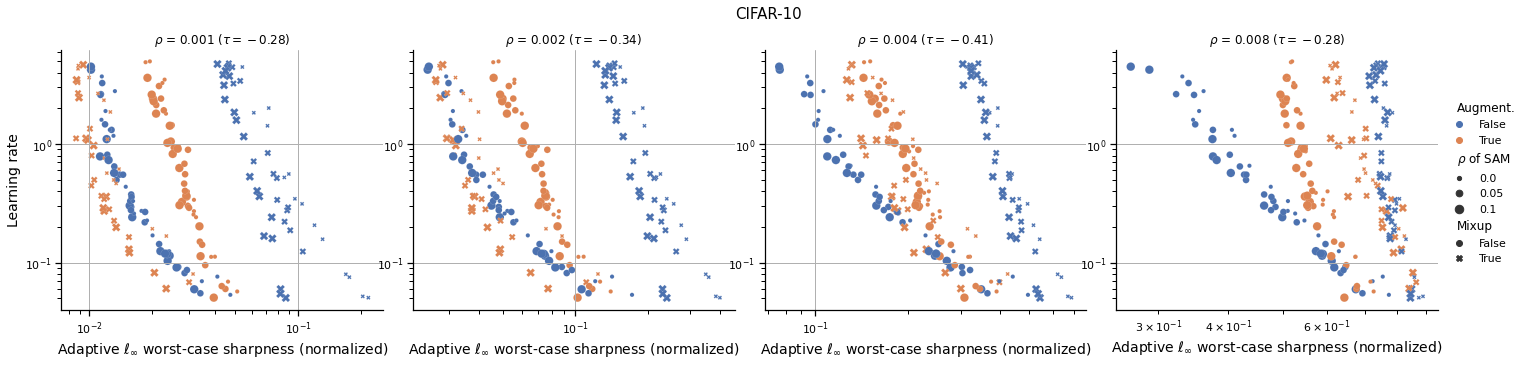

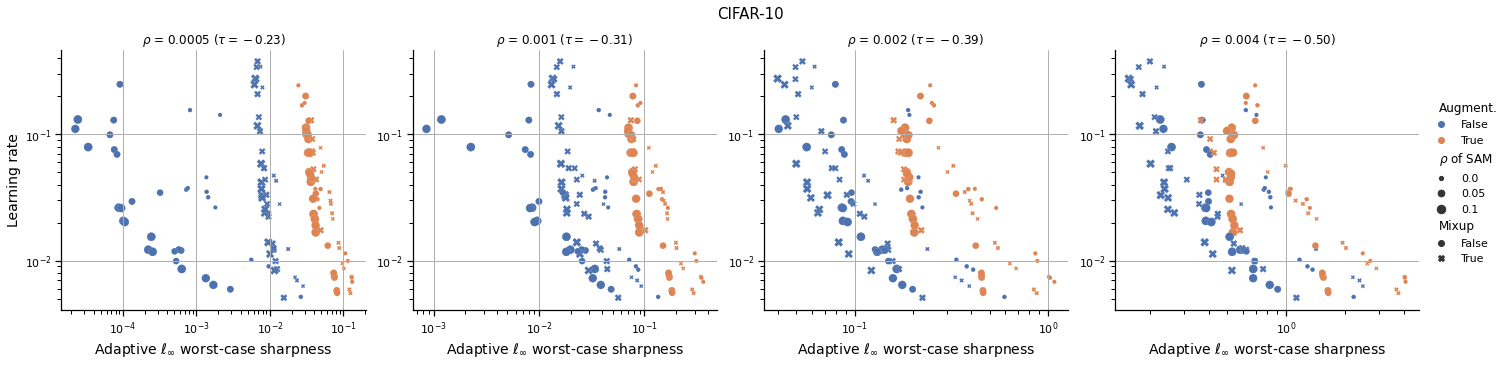

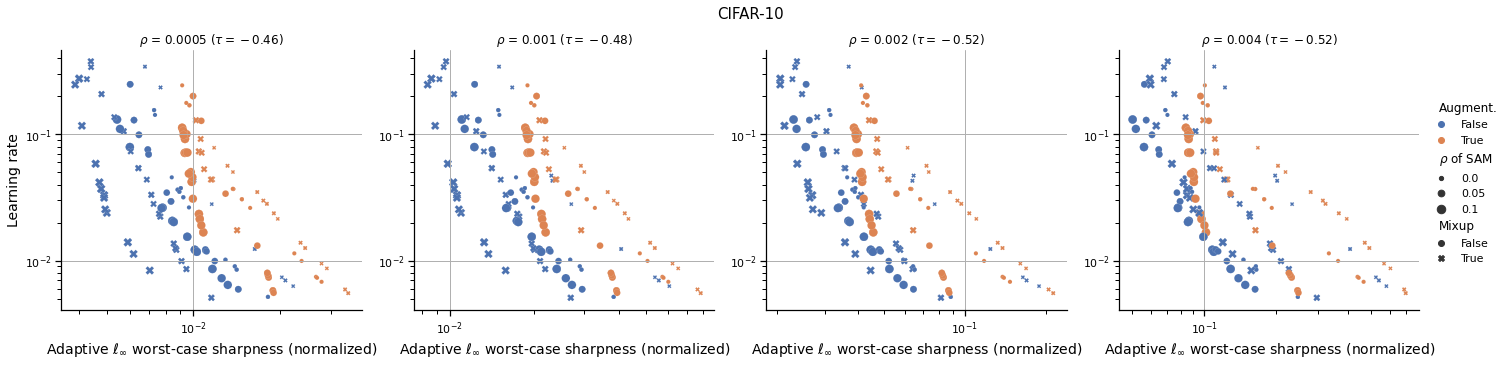

In [13]:
# slices (hue): lr, rho

# df_all = read_jsons_as_df('../logs_final_resnet_max_linf/*')
# # df_all = read_jsons_as_df('../logs_final_vit_max_linf/*')
# dataset, model = df_all['dataset'].min(), df_all['model'].min()

version = 'long'
col = 'rho'
x_name, y_name = 'sharpness_obj', 'train_lr'

for df_all in [df_all_resnet_max_linf, df_all_vit_max_linf]:
    for algorithm in ['m_apgd_linf']:
    # for algorithm in ['avg', 'avg_l2', 'avg_linf', 'm_apgd', 'm_apgd_l2', 'm_apgd_linf']:
        for adaptive in [True]:
            for normalize_logits in [False, True]:
                idx_global = (df_all['mixup'] >= False) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.1) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                if idx_global.sum() > 0:
                    df_relplot = df_all[idx_global]
                    g = sns.relplot(data=df_relplot, x=x_name, y=y_name, col="rho", hue="randaug", style="mixup", size="train_rho", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth)
                    
                    for i, col_val in enumerate(sorted(df_relplot[col].unique())):
                        idx_col = df_relplot['rho'] == col_val
                        tau, p_value = scipy.stats.kendalltau(df_relplot[x_name][idx_col], df_relplot[y_name][idx_col])
                        g.axes.flat[i].set_title(g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))
                    
                    g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                    g.set_ylabels('Learning rate', size=label_size)
                    g.set(xscale='log')
                    g.set(yscale='log')
                    # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                    g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                    g.fig.subplots_adjust(top=0.86)
                    adjust_legend(g._legend.texts)
                    plt.savefig('../plots/sharpness_vs_lr-dataset_{}-model_{}-algorithm_{}-adaptive_{}-normalized_{}-version_{}.pdf'.format(dataset, model, algorithm, adaptive, normalize_logits, version), bbox_inches='tight')

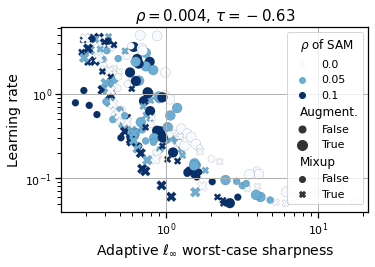

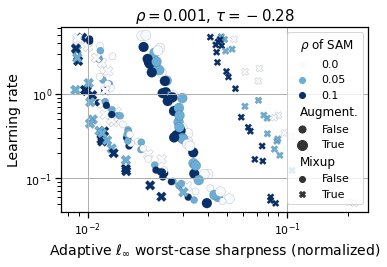

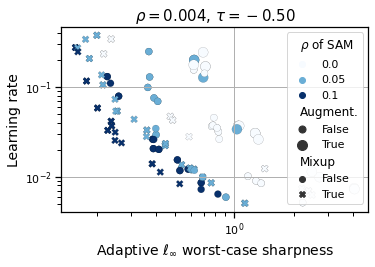

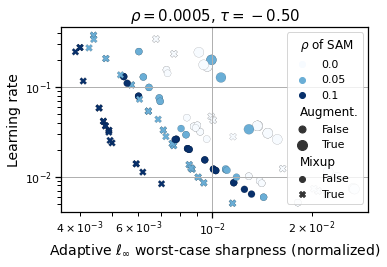

In [31]:
# slices (hue): lr, rho

version = 'short'

col = 'rho'
x_name, y_name = 'sharpness_obj', 'train_lr'

rho_idx = [2, 0, 3, 0]
i_increment = 0
for df_all in [df_all_resnet_avg_l2, df_all_resnet_max_l2, df_all_resnet_avg_linf, df_all_resnet_max_linf, df_all_vit_avg_l2, df_all_vit_max_l2, df_all_vit_avg_linf, df_all_vit_max_linf]:
    dataset, model = df_all['dataset'].min(), df_all['model'].min()
    for algorithm in ['m_apgd_linf']:
    # for algorithm in ['avg', 'avg_l2', 'avg_linf', 'm_apgd', 'm_apgd_l2', 'm_apgd_linf']:
        for adaptive in [True]:
            for normalize_logits in [False, True]:
                idx_global = (df_all['mixup'] >= False) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.01) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                if idx_global.sum() > 0:
                    idx_global = idx_global & df_all['rho'].isin(np.sort(df_all[idx_global]['rho'].unique())[[rho_idx[i_increment]]])
                    i_increment += 1
                    df_relplot = df_all[idx_global]
                    # g = sns.relplot(data=df_relplot, x=x_name, y=y_name, col="rho", hue="randaug", style="mixup", size="train_rho", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth)
                    
                    # for i, col_val in enumerate(sorted(df_relplot[col].unique())):
                    #     idx_col = df_relplot['rho'] == col_val
                    #     tau, p_value = scipy.stats.kendalltau(df_relplot[x_name][idx_col], df_relplot[y_name][idx_col])
                    #     g.axes.flat[i].set_title(g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))
                    
                    # g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                    # g.set_ylabels('Learning rate', size=label_size)
                    # g.set(xscale='log')
                    # g.set(yscale='log')
                    # # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                    # g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                    # g.fig.subplots_adjust(top=0.86)
                    # adjust_legend(g)
                    # # g.axes.flat[0].grid(color='b', linestyle='-', linewidth=1)
                    # # g.axes.flat[0].spines['top'].set_color('0.5')

                    rho = df_relplot['rho'].min()
                    # plt.figure(figsize=(5.5, 5.5))
                    plt.figure(figsize=(5.5, 3.4))
                    # hue='train_rho'
                    ax = sns.scatterplot(data=df_relplot, x=x_name, y=y_name, style="mixup", size="data_augm", hue='train_rho', linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
                    ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                    ax.set_ylabel('Learning rate', size=label_size)
                    tau, p_value = scipy.stats.kendalltau(df_relplot[x_name], df_relplot[y_name])
                    ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
                    ax.set_xscale('log')
                    ax.set_yscale('log')
                    adjust_legend(ax.get_legend().texts)

                    plt.savefig('../plots/sharpness_vs_lr-dataset_{}-model_{}-algorithm_{}-adaptive_{}-normalized_{}-version_{}.pdf'.format(dataset, model, algorithm, adaptive, normalize_logits, version), bbox_inches='tight')

In [13]:
df_all_resnet_max_linf = read_jsons_as_df('../logs_final_resnet_max_linf/*')
df_all_vit_max_linf = read_jsons_as_df('../logs_final_vit_max_linf/*')
print(df_all_resnet_max_linf.shape, df_all_vit_max_linf.shape)

(5393, 51) (4938, 51)


(4938, 51)


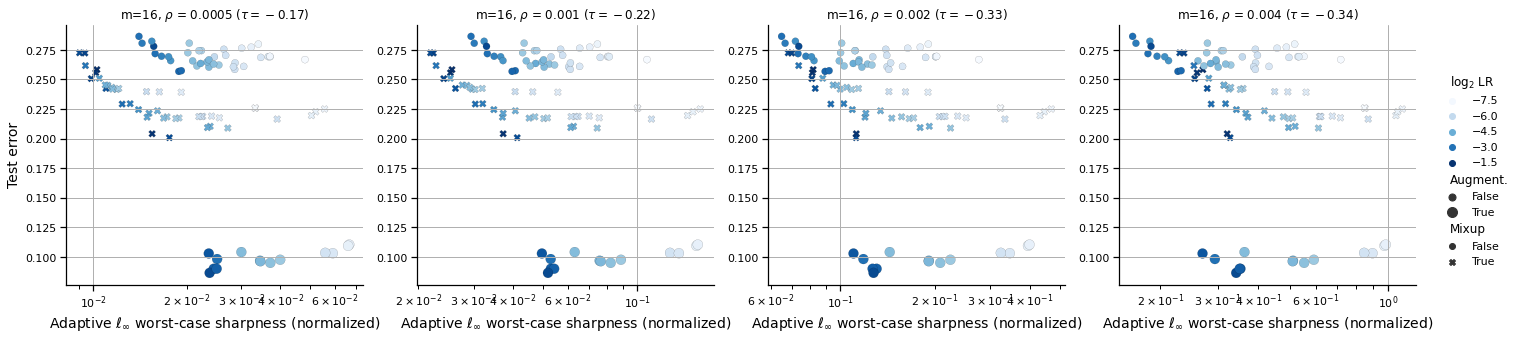

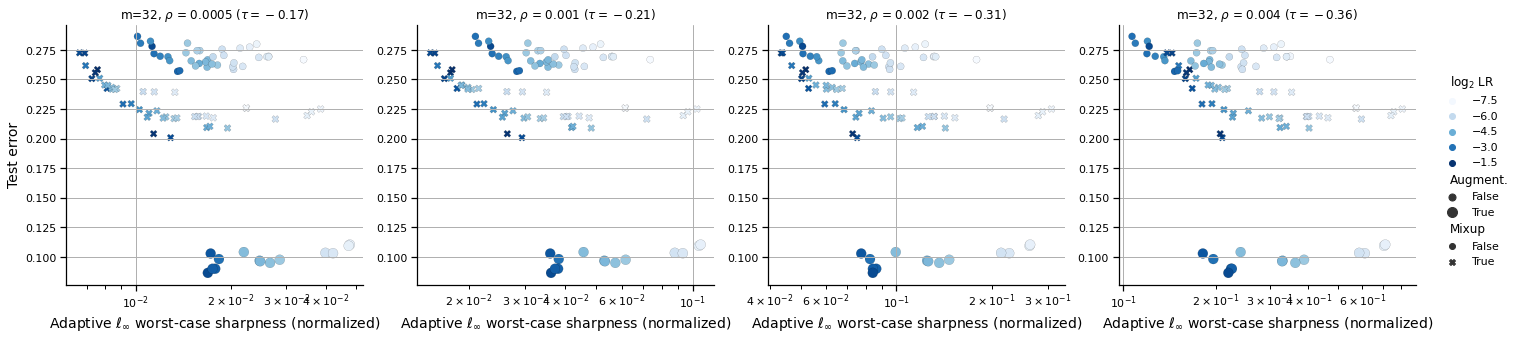

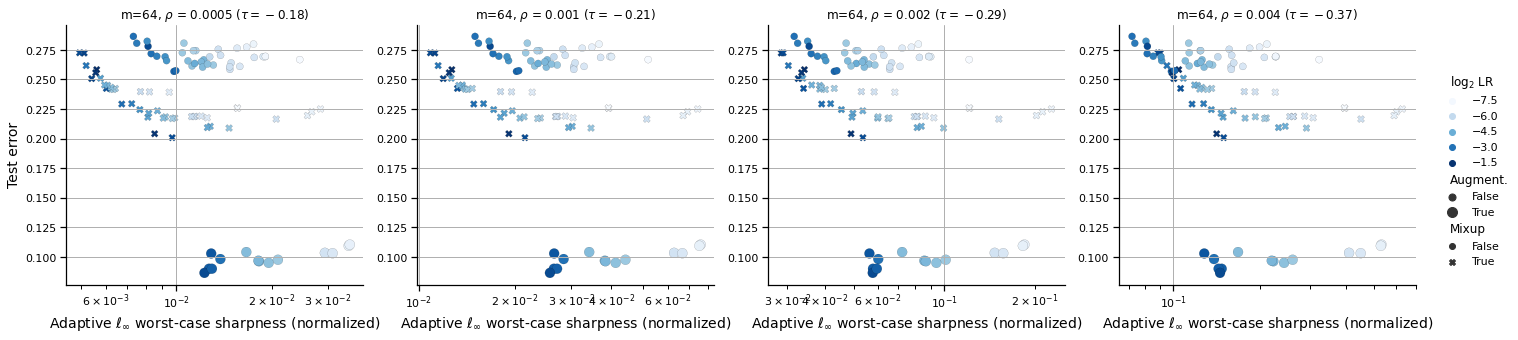

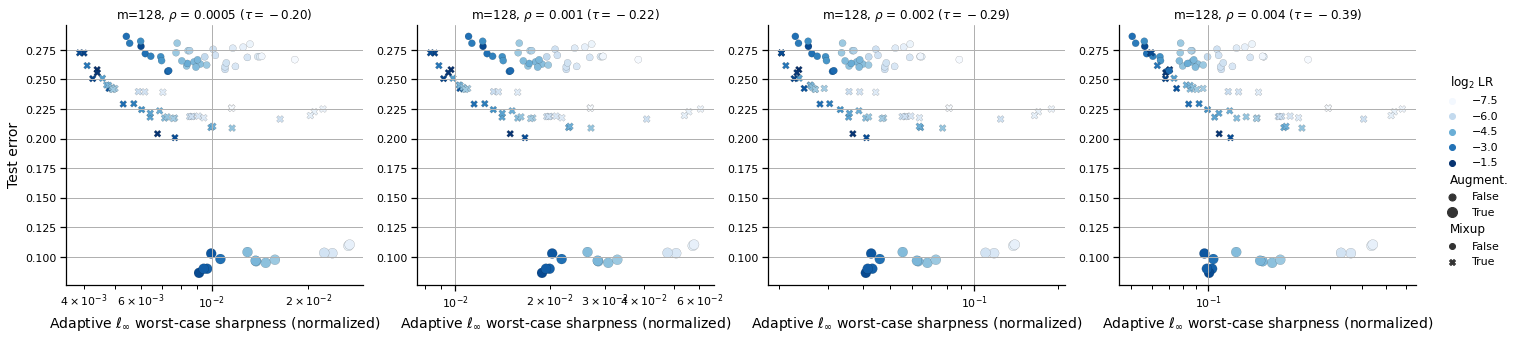

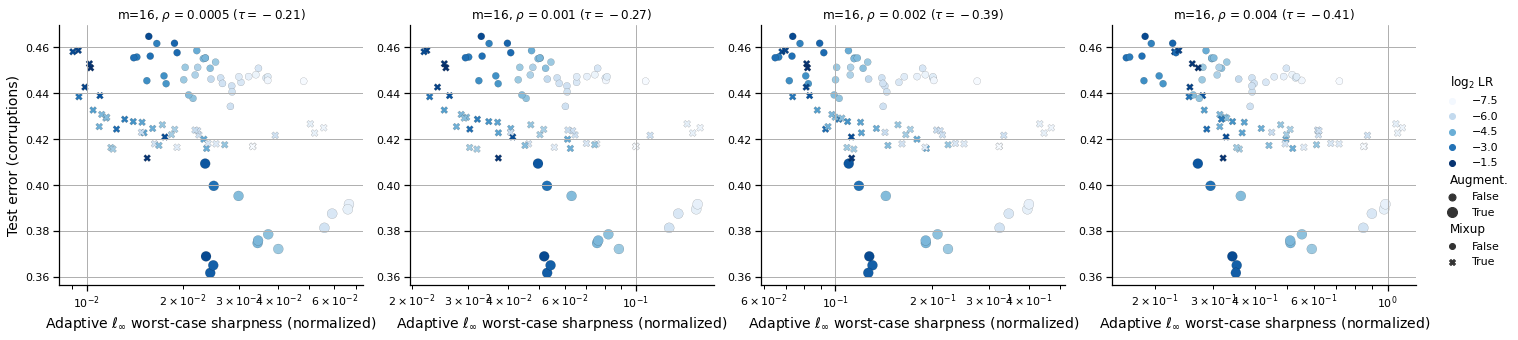

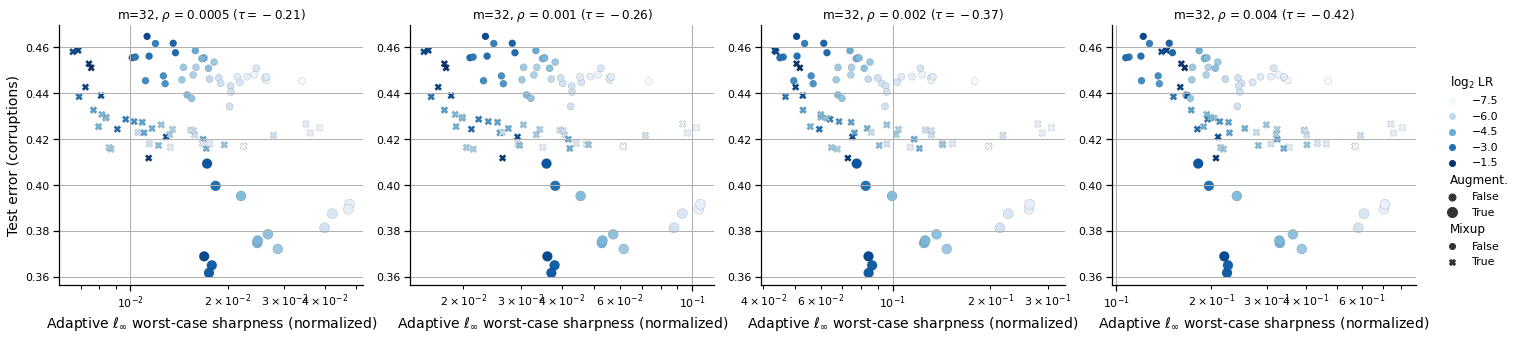

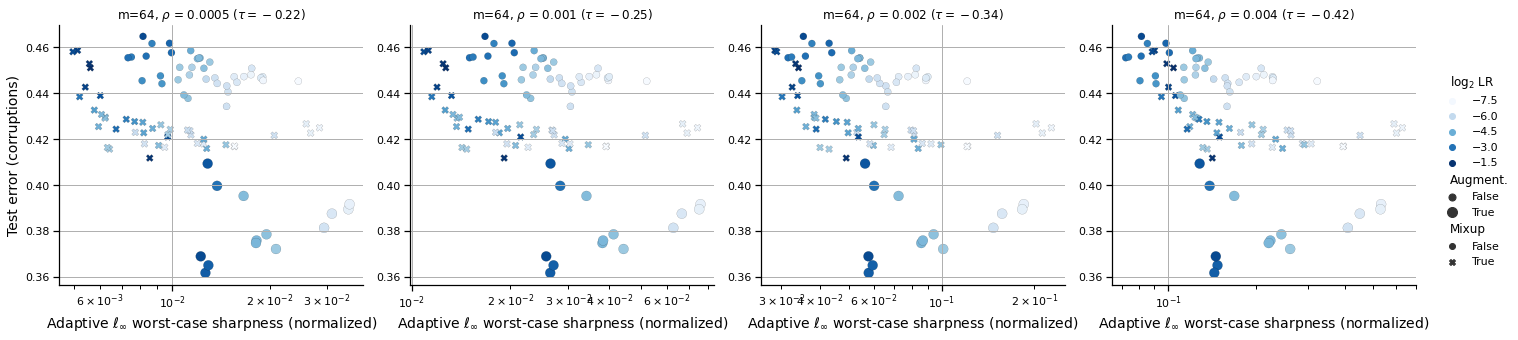

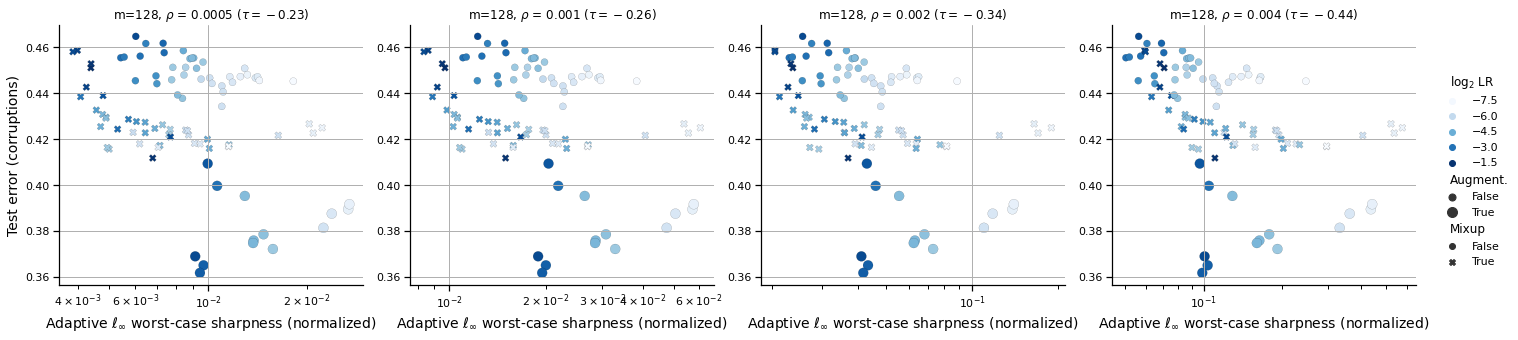

(5393, 51)


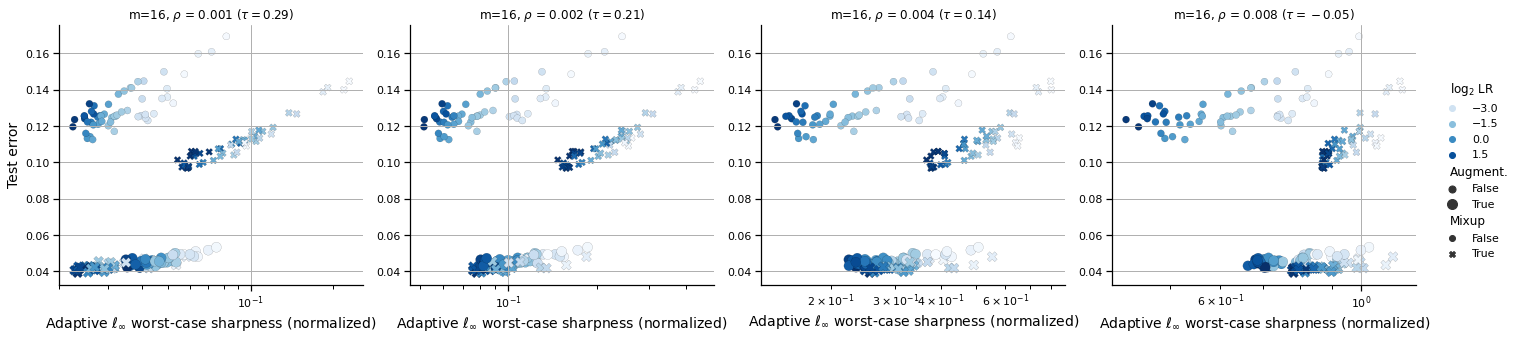

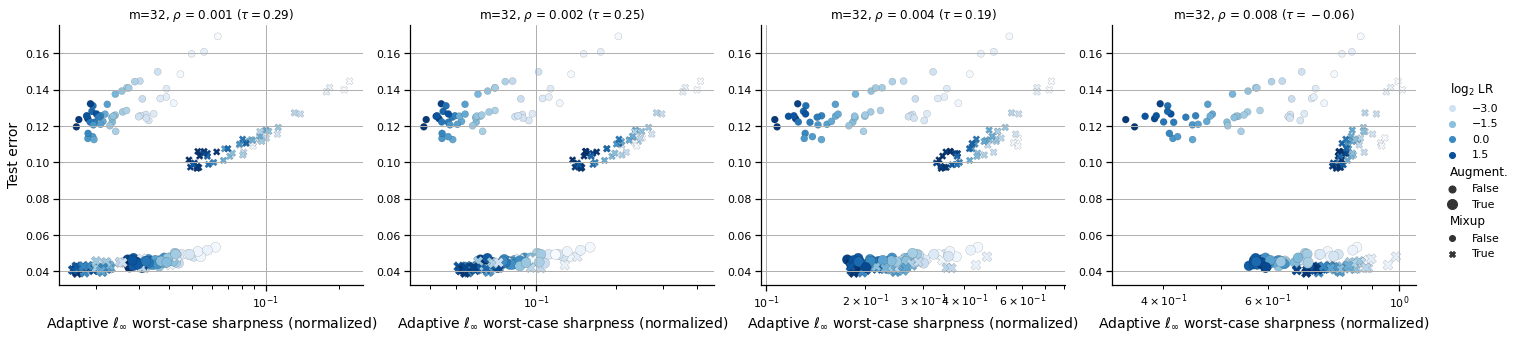

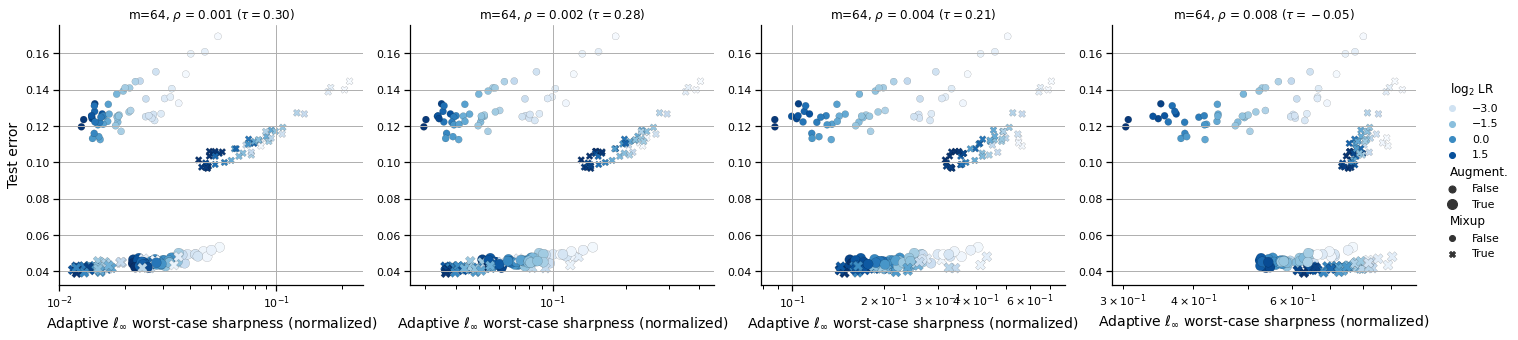

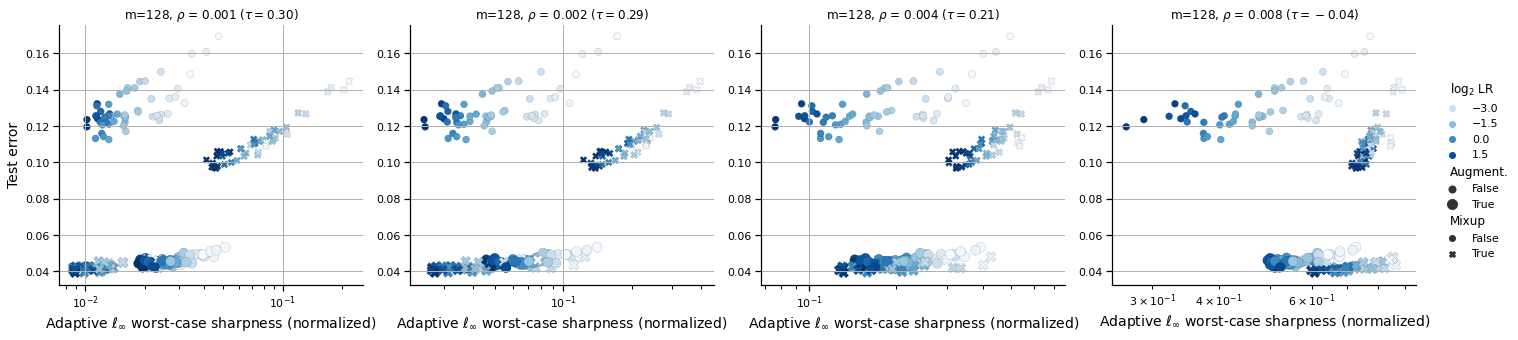

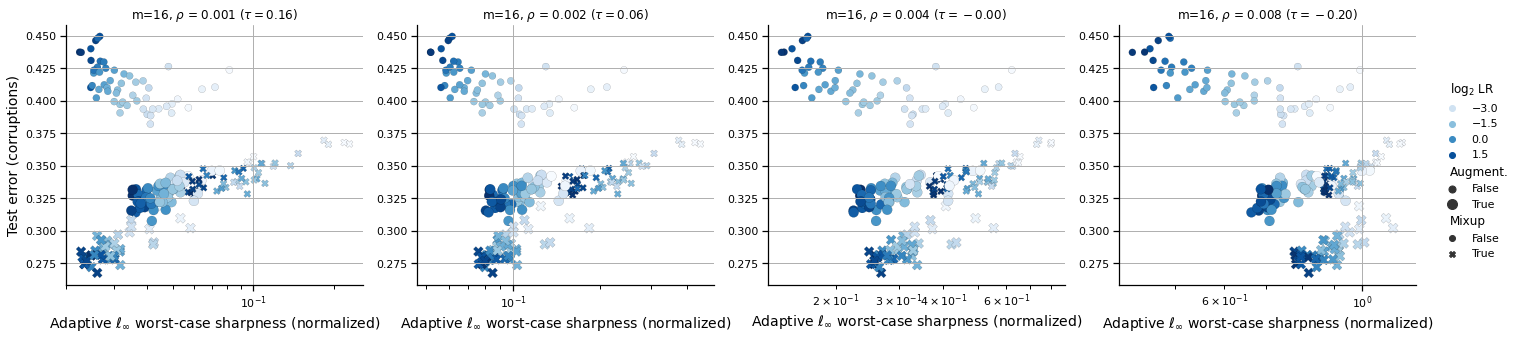

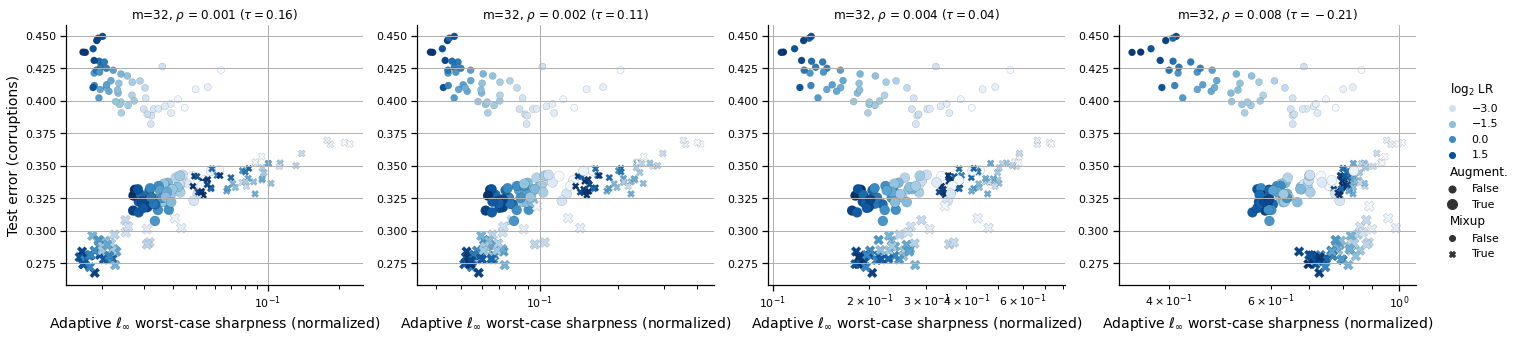

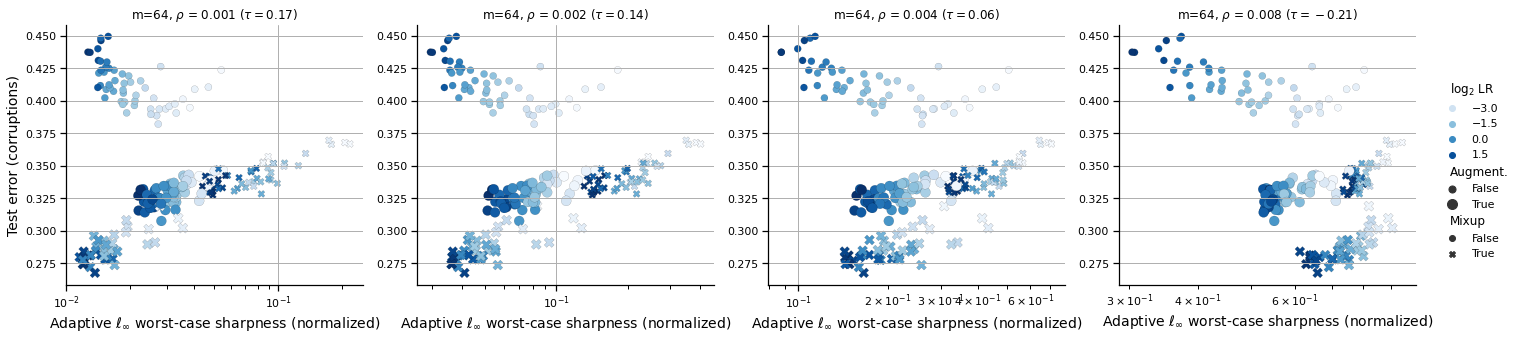

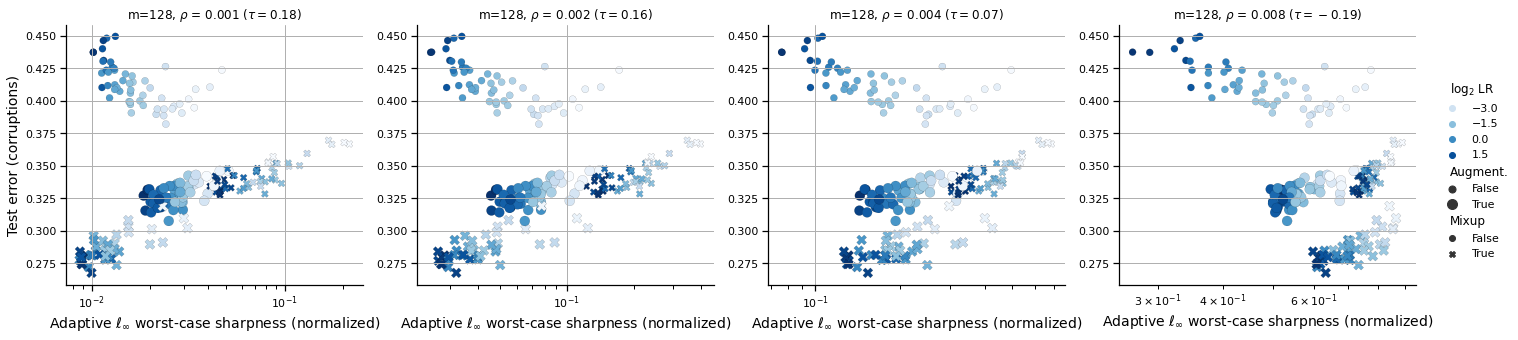

In [14]:
### m-sharpness

for df_all in [df_all_resnet_max_linf, df_all_vit_max_linf][::-1]:
    print(df_all.shape)
    dataset, model = df_all['dataset'].min(), df_all['model'].min()
    for version in ['long']:
        for err in ['test_err', 'test_err_corrupt']:  #, 'test_err_corrupt']:
            # for algorithm in ['m_apgd_linf']:
            for algorithm in ['avg', 'avg_l2', 'avg_linf', 'm_apgd', 'm_apgd_l2', 'm_apgd_linf']:
                adaptive, normalize_logits = True, True
                for bs_sharpness in [16, 32, 64, 128]:
                    idx_global = (df_all['mixup'] >= False) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.01) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == bs_sharpness) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                    if idx_global.sum() > 0:
                        if version == 'short':
                            idx_global = idx_global & df_all['rho'].isin(np.sort(df_all[idx_global]['rho'].unique())[[0]])
                        df_relplot = df_all[idx_global].drop_duplicates(subset=['model_path', 'rho'])  # there could be duplicates due to crashes + rerunning (22:56 23 Jan crash time for 2th, 5th, and 6th ViTs worst-case runs)
                        # size: train_lr, train_rho
                        # style: model_type, randaug, mixup

                        if version == 'short':
                            rho = df_relplot['rho'].min()
                            # plt.figure(figsize=(5.5, 5.5))
                            plt.figure(figsize=(5.5, 3.8))
                            ax = sns.scatterplot(data=df_relplot, x="sharpness_obj", y=err, hue="train_lr_log", style="mixup", size="data_augm", linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
                            ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                            ax.set_ylabel(err_dict[err], size=label_size)
                            tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'], df_relplot[err])
                            ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
                            ax.set_xscale('log')
                            adjust_legend(ax.get_legend().texts)
                            if algorithm != 'm_apgd_linf':
                                ax.get_legend().remove()
                                # g._legend.remove()
                        else:
                            g = sns.relplot(data=df_relplot, x="sharpness_obj", y=err, col="rho", hue="train_lr_log", style="mixup", size="data_augm", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)
                            
                            for i, rho in enumerate(sorted(df_relplot['rho'].unique())):
                                idx_rho = df_relplot['rho'] == rho
                                tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'][idx_rho], df_relplot[err][idx_rho])
                                g.axes.flat[i].set_title('m={}, '.format(bs_sharpness) + g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))

                            g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                            g.set_ylabels(err_dict[err], size=label_size)
                            g.set(xscale='log')
                            # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                            # g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                            g.fig.subplots_adjust(top=0.86)
                            adjust_legend(g._legend.texts)
                        plt.savefig('../plots/sharpness_vs_generalization_diff_m-dataset_{}-model_{}-{}-algorithm_{}-adaptive_{}-normalized_{}-m_{}.pdf'.format(dataset, model, err, algorithm, adaptive, normalize_logits, bs_sharpness), bbox_inches='tight')
                        plt.show()
                        # if version == 'long':
                        #     plt.show()
                        # else:
                        #     plt.clf()


In [2]:
df_all_resnet_avg_linf = read_jsons_as_df('../logs_final_resnet_avg_linf_more_n_iters/*')
df_all_resnet_avg_linf_randaug = read_jsons_as_df('../logs_final_resnet_avg_linf_more_n_iters_randaug/*')

(198, 5) (198, 5)


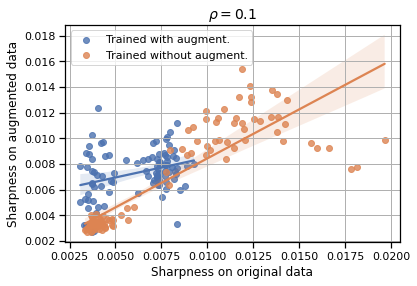

(198, 5) (198, 5)


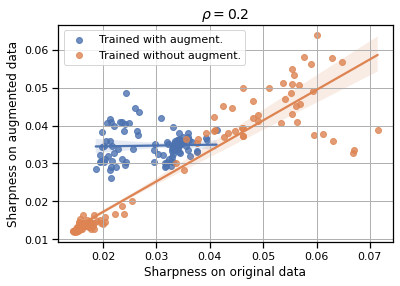

(198, 5) (198, 5)


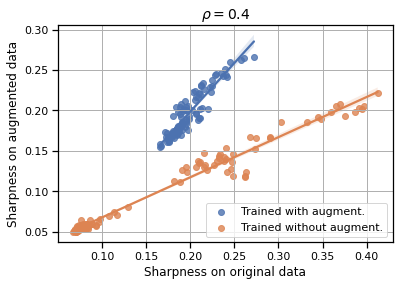

(198, 5) (198, 5)


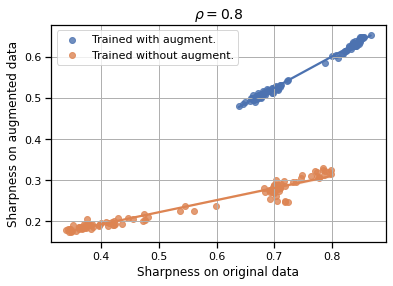

In [40]:
normalize_logits, adaptive, algorithm = True, True, 'avg_linf'
for rho in [0.1, 0.2, 0.4, 0.8]:
    df1 = df_all_resnet_avg_linf[(df_all_resnet_avg_linf['normalize_logits'] == normalize_logits) & (df_all_resnet_avg_linf['rho'] == rho)][['model_path', 'sharpness_obj', 'rho', 'mixup', 'randaug']]
    df2 = df_all_resnet_avg_linf_randaug[(df_all_resnet_avg_linf_randaug['normalize_logits'] == normalize_logits) & (df_all_resnet_avg_linf_randaug['rho'] == rho)][['model_path', 'sharpness_obj', 'rho', 'mixup', 'randaug']]
    df1 = df1.rename(columns={'sharpness_obj': 'sharpness_obj_orig'})
    df2 = df2.rename(columns={'sharpness_obj': 'sharpness_obj_augm'})
    print(df1.shape, df2.shape)
    df_merged = pd.merge(df1, df2, on=['model_path'])
    df_merged = df_merged[df_merged['rho_x'] == df_merged['rho_y']]
    df_merged['rho'] = df_merged['rho_x']

    # ax = sns.scatterplot(data=df_merged, x="sharpness_obj_orig", y="sharpness_obj_augm")
    ax = sns.regplot(data=df_merged[df_merged['randaug_x'] == True], x="sharpness_obj_orig", y="sharpness_obj_augm", label='Trained with augment.')
    ax = sns.regplot(data=df_merged[df_merged['randaug_x'] == False], x="sharpness_obj_orig", y="sharpness_obj_augm", label='Trained without augment.')
    # ax.set_xlabel('{} on original data'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''))
    # ax.set_ylabel('{} on augmented data'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''))
    ax.set_xlabel('Sharpness on original data')
    ax.set_ylabel('Sharpness on augmented data')
    ax.legend()

    # identity_vals = np.linspace(df_merged['sharpness_obj_augm'].min(), df_merged['sharpness_obj_orig'].max(), 100)
    # plt.plot(identity_vals, identity_vals, color='r')
    plt.title('$\\rho = {}$'.format(rho), fontsize=14)
    plt.savefig('../plots/orig_vs_da-dataset_cifar10-model_resnet18-algorithm_{}-adaptive_{}-normalized_{}-rho_{}.pdf'.format(algorithm, adaptive, normalize_logits, rho), bbox_inches='tight')
    plt.show()

(2376, 50)


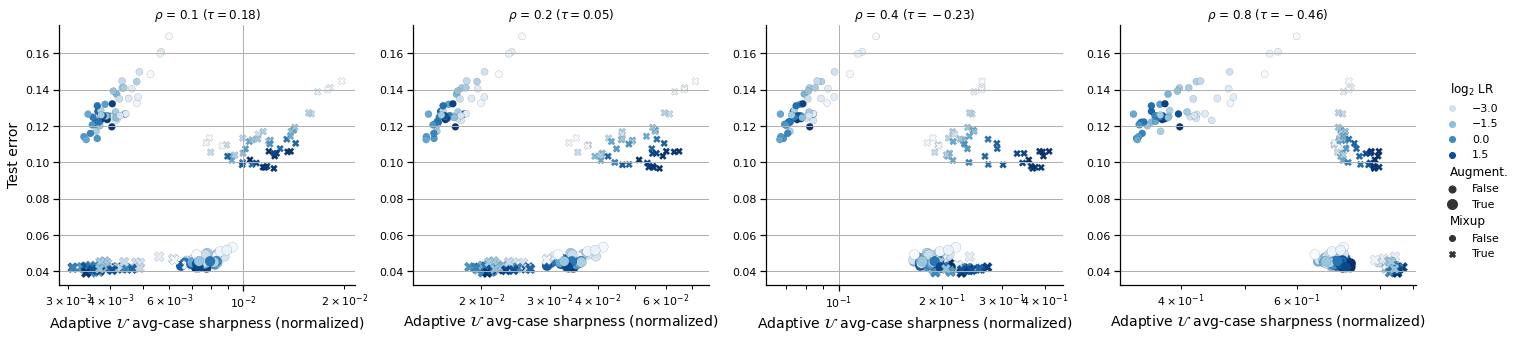

(2376, 52)


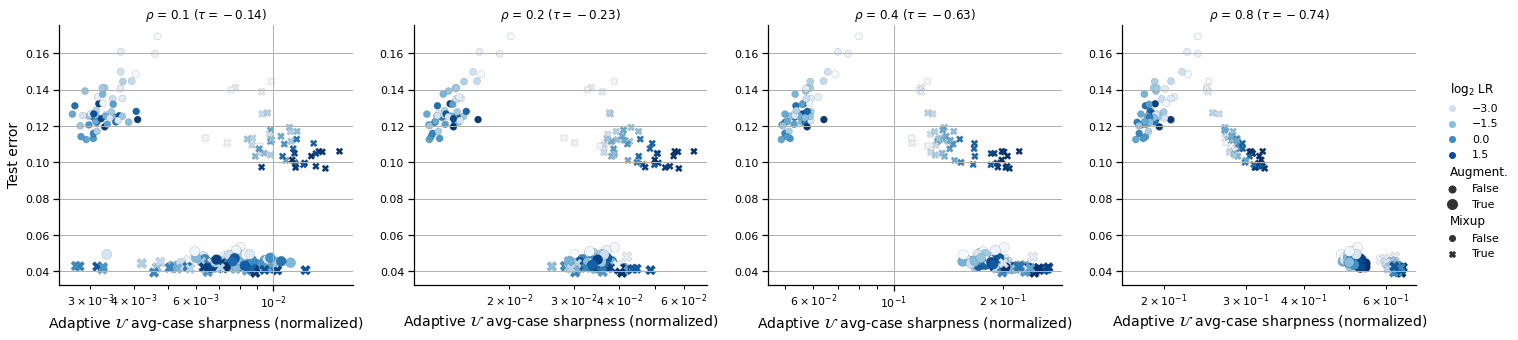

In [10]:

for df_all, randaug in zip([df_all_resnet_avg_linf, df_all_resnet_avg_linf_randaug], [False, True]):
    print(df_all.shape)
    dataset, model = df_all['dataset'].min(), df_all['model'].min()

    for version in ['long']:  # ['long', 'short']:
        for err in ['test_err']:  #, 'test_err_corrupt']:
            # for algorithm in ['m_apgd_linf']:
            for algorithm in ['avg_linf']:
                for adaptive in [True]:
                    for normalize_logits in [True]:
                        idx_global = (df_all['mixup'] >= False) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.01) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                        if idx_global.sum() > 0:
                            if version == 'short':
                                idx_global = idx_global & df_all['rho'].isin(np.sort(df_all[idx_global]['rho'].unique())[[0]])
                            df_relplot = df_all[idx_global].drop_duplicates(subset=['model_path', 'rho'])  # there could be duplicates due to crashes + rerunning (22:56 23 Jan crash time for 2th, 5th, and 6th ViTs worst-case runs)
                            # size: train_lr, train_rho
                            # style: model_type, randaug, mixup

                            if version == 'short':
                                rho = df_relplot['rho'].min()
                                # plt.figure(figsize=(5.5, 5.5))
                                plt.figure(figsize=(5.5, 3.8))
                                ax = sns.scatterplot(data=df_relplot, x="sharpness_obj", y=err, hue="train_lr_log", style="mixup", size="data_augm", linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
                                ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                ax.set_ylabel(err_dict[err], size=label_size)
                                tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'], df_relplot[err])
                                ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
                                ax.set_xscale('log')
                                adjust_legend(ax.get_legend().texts)
                                if algorithm != 'm_apgd_linf':
                                    ax.get_legend().remove()
                                    # g._legend.remove()
                            else:
                                g = sns.relplot(data=df_relplot, x="sharpness_obj", y=err, col="rho", hue="train_lr_log", style="mixup", size="data_augm", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)
                                
                                for i, rho in enumerate(sorted(df_relplot['rho'].unique())):
                                    idx_rho = df_relplot['rho'] == rho
                                    tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'][idx_rho], df_relplot[err][idx_rho])
                                    g.axes.flat[i].set_title(g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))

                                g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                g.set_ylabels(err_dict[err], size=label_size)
                                g.set(xscale='log')
                                # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                                # g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                                g.fig.subplots_adjust(top=0.86)
                                adjust_legend(g._legend.texts)
                            plt.savefig('../plots/s_vs_g_randaug_{}-dataset_{}-model_{}-{}-algorithm_{}-adaptive_{}-normalized_{}-version_{}.pdf'.format(randaug, dataset, model, err, algorithm, adaptive, normalize_logits, version), bbox_inches='tight')
                            plt.show()
                            # if version == 'long':
                            #     plt.show()
                            # else:
                            #     plt.clf()


In [5]:
df_all_resnet_max_linf = read_jsons_as_df('../logs_final_resnet_max_linf/*')
df_all_resnet_max_linf_diff_n_iters = read_jsons_as_df('../logs_final_resnet_max_linf_diff_n_iters/*')

(5393, 51)
0.25447085874173936


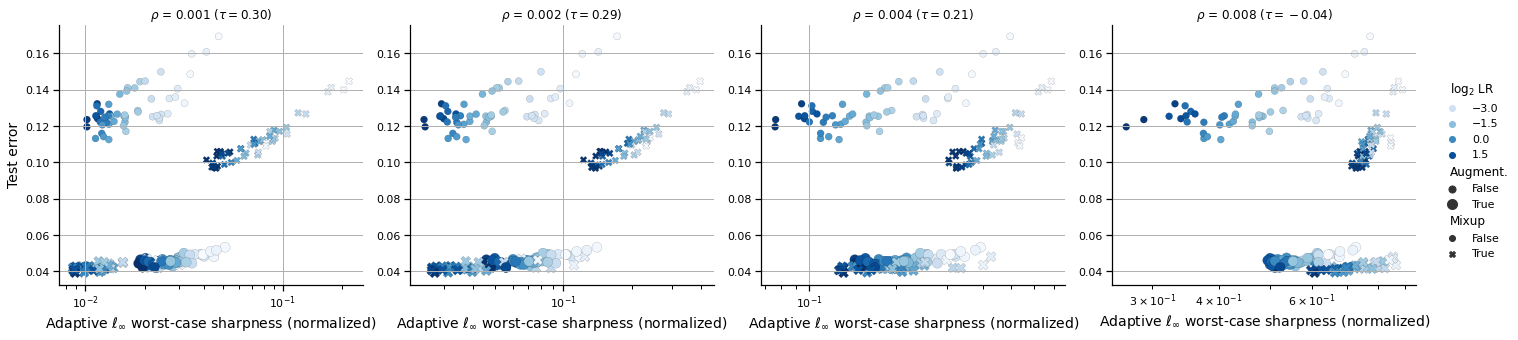

(2376, 52)
0.2585571559541149


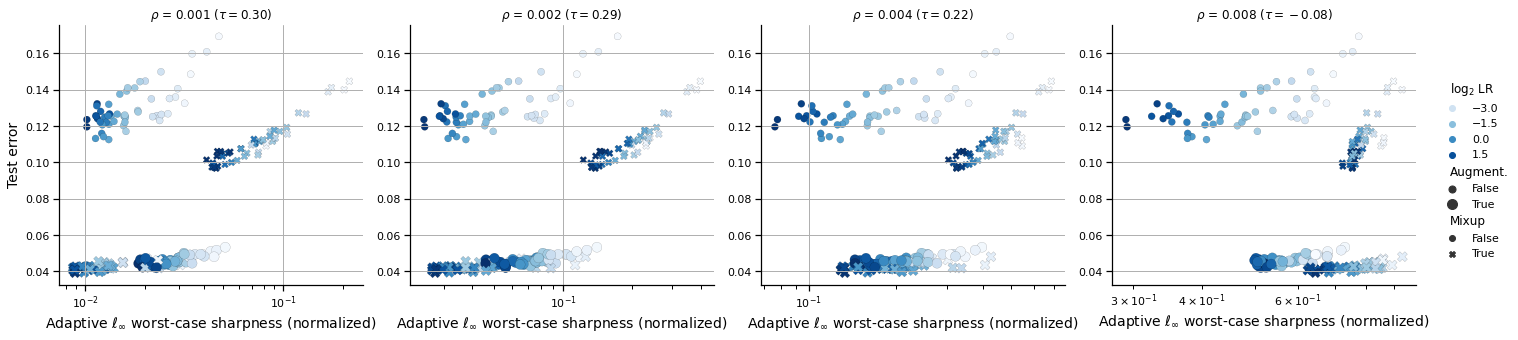

0.25955646517075026


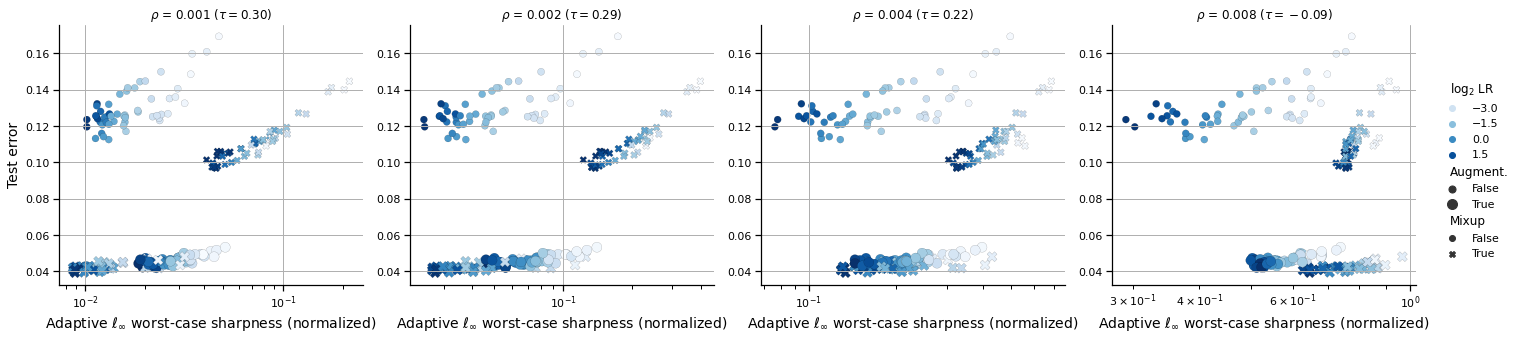

0.2600068381865213


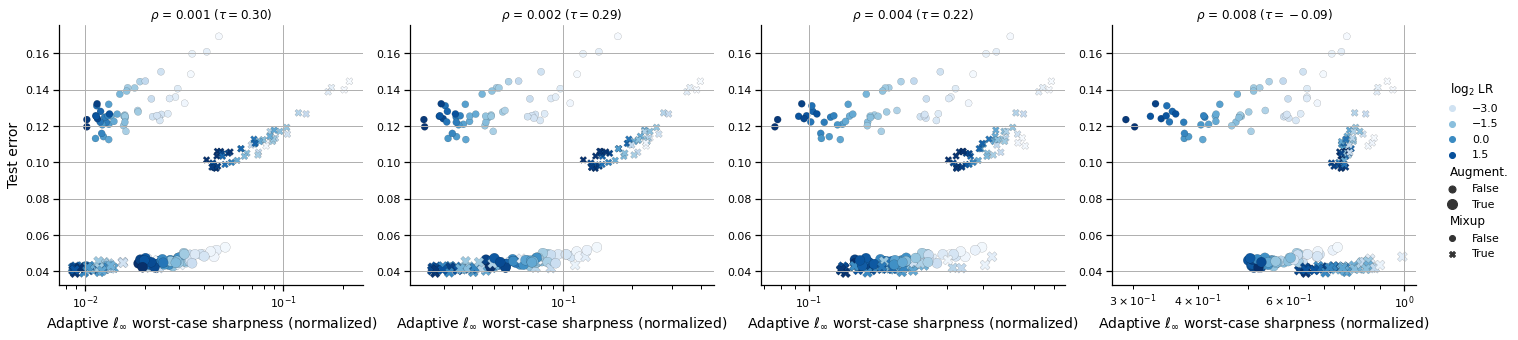

In [6]:
# for df_all in [df_all_resnet_avg_l2, df_all_resnet_max_l2, df_all_resnet_avg_linf, df_all_resnet_max_linf, df_all_vit_avg_l2, df_all_vit_max_l2, df_all_vit_avg_linf, df_all_vit_max_linf]:
for df_all in [df_all_resnet_max_linf, df_all_resnet_max_linf_diff_n_iters]:
    print(df_all.shape)
    for n_iters in [20, 50, 100, 200]:
        dataset, model = df_all['dataset'].min(), df_all['model'].min()
        for version in ['long']:  # ['long', 'short']:
            for err in ['test_err']:  #, 'test_err_corrupt']:
                for algorithm in ['m_apgd_linf']:
                    for adaptive in [True]:
                        for normalize_logits in [True]:
                            idx_global = (df_all['mixup'] >= False) & (df_all['n_iters'] == n_iters) & (df_all['train_rho'] >= 0.0) & (df_all['train_err'] >= 0.0) & (df_all['train_err'] <= 0.01) & (df_all['test_err'] >= 0.0) & (df_all['test_err'] <= 1.0) & (df_all['bs_sharpness'] == 128) & (df_all['algorithm'] == algorithm) & (df_all['adaptive'] == adaptive) & (df_all['normalize_logits'] == normalize_logits)
                            if idx_global.sum() > 0:
                                if version == 'short':
                                    idx_global = idx_global & df_all['rho'].isin(np.sort(df_all[idx_global]['rho'].unique())[[0]])
                                df_relplot = df_all[idx_global].drop_duplicates(subset=['model_path', 'rho'])  # there could be duplicates due to crashes + rerunning (22:56 23 Jan crash time for 2th, 5th, and 6th ViTs worst-case runs)
                                print(df_relplot['sharpness_obj'].mean())
                                # size: train_lr, train_rho
                                # style: model_type, randaug, mixup

                                if version == 'short':
                                    rho = df_relplot['rho'].min()
                                    # plt.figure(figsize=(5.5, 5.5))
                                    plt.figure(figsize=(5.5, 3.8))
                                    ax = sns.scatterplot(data=df_relplot, x="sharpness_obj", y=err, hue="train_lr_log", style="mixup", size="data_augm", linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)#palette=sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))  # palette=sns.color_palette("Blues", as_cmap=True)
                                    ax.set_xlabel('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                    ax.set_ylabel(err_dict[err], size=label_size)
                                    tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'], df_relplot[err])
                                    ax.set_title('$\\rho={}$, $\\tau={:.2f}$'.format(rho, tau), fontsize=15)
                                    ax.set_xscale('log')
                                    adjust_legend(ax.get_legend().texts)
                                    if algorithm != 'm_apgd_linf':
                                        ax.get_legend().remove()
                                        # g._legend.remove()
                                else:
                                    g = sns.relplot(data=df_relplot, x="sharpness_obj", y=err, col="rho", hue="train_lr_log", style="mixup", size="data_augm", kind="scatter", facet_kws={'sharex': False, 'sharey': False}, linewidth=linewidth, edgecolor=edgecolor, sizes=sizes, palette=palette)
                                    
                                    for i, rho in enumerate(sorted(df_relplot['rho'].unique())):
                                        idx_rho = df_relplot['rho'] == rho
                                        tau, p_value = scipy.stats.kendalltau(df_relplot['sharpness_obj'][idx_rho], df_relplot[err][idx_rho])
                                        g.axes.flat[i].set_title(g.axes.flat[i].title.get_text().replace('rho', '$\\rho$') + ' ($\\tau={:.2f}$)'.format(tau))

                                    g.set_xlabels('{}'.format(sharpness_dict[algorithm][adaptive]) + (' (normalized)' if normalize_logits else ''), size=label_size)
                                    g.set_ylabels(err_dict[err], size=label_size)
                                    g.set(xscale='log')
                                    # g.fig.suptitle('{}, {}'.format(dataset_dict[dataset], sharpness_dict[algorithm][adaptive].lower()), fontsize=title_size)
                                    # g.fig.suptitle('{}'.format(dataset_dict[dataset]), fontsize=title_size)
                                    g.fig.subplots_adjust(top=0.86)
                                    adjust_legend(g._legend.texts)
                                plt.savefig('../plots/s_vs_g_diff_n_iters-dataset_{}-model_{}-{}-algorithm_{}-adaptive_{}-normalized_{}-version_{}_n_iters_{}.pdf'.format(dataset, model, err, algorithm, adaptive, normalize_logits, version, n_iters), bbox_inches='tight')
                                plt.show()
                                # if version == 'long':
                                #     plt.show()
                                # else:
                                #     plt.clf()
